# HOML Ch.14 Exercise 9

### Exercise: Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [ ]:
tf.random.set_seed(999)
np.random.seed(999)

Let's start by loading the dataset, rescaling it, and splitting it into training, validation, and test sets.

In [ ]:
(X_train_all, y_train_all), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_all = X_train_all / 255.
X_test = X_test / 255.
X_train, X_val = X_train_all[:-5000], X_train_all[-5000:]
y_train, y_val = y_train_all[:-5000], y_train_all[-5000:]

11493376/11490434 [==============================] - 0s 0us/step


We need to convert this to a 2d array, which we can do with np.newaxis.

In [ ]:
# Add additional dimensions: https://note.nkmk.me/en/python-numpy-newaxis/
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

To construct our model, we're going to build upon a model that the author built with which he achieved 99.2% accuracy. We'll add an additional Conv2D 128 layer to the existing Conv2D layers and repeat the three layers, putting a max pooling layer after each set of three convolutional layers. 

The author mentioned that 99.5% accuracy may be possible if batch normalization, which standardizes the inputs and speeds up training, is added (in addition to data augmentation, a learning rate scheduler, and using an ensemble model). So, we've added a couple of batch norm layers - one after the Flatten layer and another after the Dense ReLU layer.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

We'll add a Model Checkpoint callback to save the model with the best validation loss.

In [ ]:
mod_chkpnt = keras.callbacks.ModelCheckpoint("mnist_model.h5", save_best_only=True)

We'll use a Nadam optimizer with the default learning rate of 0.001.

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[mod_chkpnt])

Epoch 1/10
1719/1719 [==============================] - 51s 10ms/step - loss: 0.1438 - accuracy: 0.9572 - val_loss: 0.0443 - val_accuracy: 0.9864
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0664 - accuracy: 0.9797 - val_loss: 0.0398 - val_accuracy: 0.9900
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0559 - accuracy: 0.9831 - val_loss: 0.0341 - val_accuracy: 0.9898
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0463 - accuracy: 0.9856 - val_loss: 0.0433 - val_accuracy: 0.9896
Epoch 5/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0409 - accuracy: 0.9878 - val_loss: 0.0312 - val_accuracy: 0.9928
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0366 - accuracy: 0.9888 - val_loss: 0.0340 - val_accuracy: 0.9902
Epoch 7/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0367 - accuracy: 0.9888 - val_loss: 0.0292 -

In [ ]:
model = keras.models.load_model("mnist_model.h5")

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0189 - accuracy: 0.9937


[0.018855394795536995, 0.9937000274658203]

With the additonal layers, we've already achieved a slightly higher accuracy than the author - 99.3%. The author suggested that we can potentially achieve at least 99.5% accuracy if we also use a learning rate scheduler to find an optimal learning rate. Let's try that below.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(999)
np.random.seed(999)

In [ ]:
# Learning rate scheduler that drops the learning rate based on the factor and patience (after how many epochs)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=3)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

optimizer = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

n_epochs = 25

history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 19s 10ms/step - loss: 0.1448 - accuracy: 0.9564 - val_loss: 0.0347 - val_accuracy: 0.9908
Epoch 2/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0692 - accuracy: 0.9795 - val_loss: 0.0412 - val_accuracy: 0.9890
Epoch 3/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0561 - accuracy: 0.9834 - val_loss: 0.0291 - val_accuracy: 0.9900
Epoch 4/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0480 - accuracy: 0.9849 - val_loss: 0.0535 - val_accuracy: 0.9844
Epoch 5/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0434 - accuracy: 0.9869 - val_loss: 0.0357 - val_accuracy: 0.9918
Epoch 6/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0388 - accuracy: 0.9875 - val_loss: 0.0395 - val_accuracy: 0.9890
Epoch 7/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.0212 -

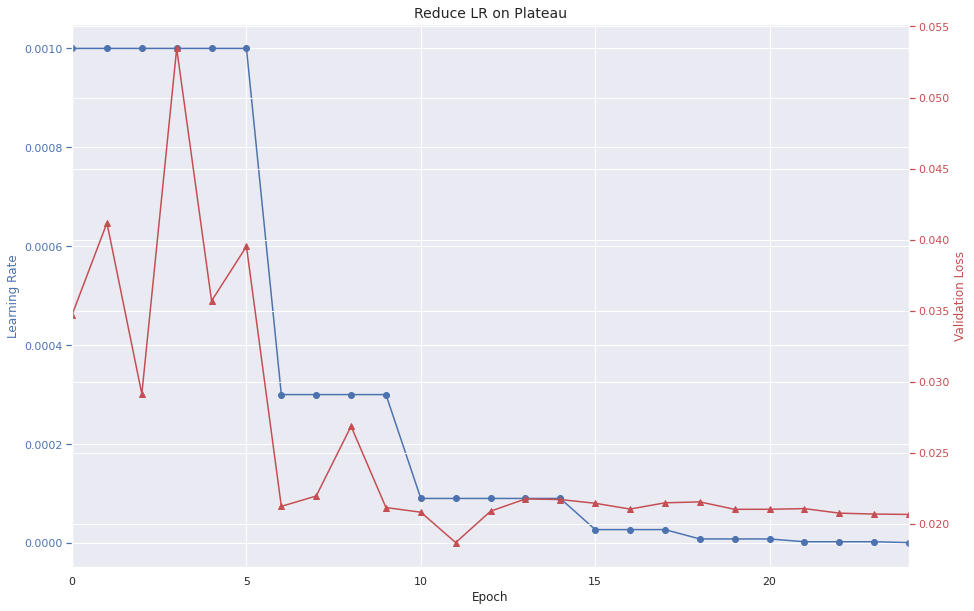

In [ ]:
# Graph learning rate scheduler results
plt.figure(figsize=(15, 10))
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

The learning scheduler rate results suggest that our optimal learning rate should be 0.0001. Let's rerun the model with this new value.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(999)
np.random.seed(999)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

optimizer = keras.optimizers.Nadam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), callbacks=[mod_chkpnt])

Epoch 1/15
1719/1719 [==============================] - 19s 10ms/step - loss: 0.2333 - accuracy: 0.9288 - val_loss: 0.0424 - val_accuracy: 0.9884
Epoch 2/15
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0809 - accuracy: 0.9758 - val_loss: 0.0315 - val_accuracy: 0.9914
Epoch 3/15
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0589 - accuracy: 0.9825 - val_loss: 0.0261 - val_accuracy: 0.9920
Epoch 4/15
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0472 - accuracy: 0.9857 - val_loss: 0.0383 - val_accuracy: 0.9880
Epoch 5/15
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0406 - accuracy: 0.9876 - val_loss: 0.0290 - val_accuracy: 0.9912
Epoch 6/15
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0342 - accuracy: 0.9901 - val_loss: 0.0270 - val_accuracy: 0.9924
Epoch 7/15
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0297 - accuracy: 0.9910 - val_loss: 0.0218 -

In [ ]:
model = keras.models.load_model("mnist_model.h5")

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0152 - accuracy: 0.9951


[0.01516395527869463, 0.9951000213623047]

As the author suggested, the learning rate scheduler helped. We were able to achieve 99.5% accuracy. He also recommended trying data augmentation and building an ensemble model. For the sake of time, we'll save those suggestions for a later time if we choose to revisit this exercise.